In [64]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = '_x4_v4_n5'
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [70]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1_x4_v4_n5.yaml
../configs/scalar_TNG100-1_x4_v4_n5.yaml


In [71]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [72]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [73]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [74]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [75]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [ ]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading


In [ ]:
print(scalar_featurizer.scalar_features.shape)

## Other features

In [14]:
x_dict = {}
x_extra_dict = {}

In [15]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None

catalog_feature_names = ['M200c', 'c200c', 'a_form']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x_dict['catalog'] = sim_reader.x_catalog_features
x_extra_dict['catalog'] = None

## Gather properties

In [16]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [17]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [18]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

# mstellar

In [31]:
y_label_name = 'm_stellar'

In [32]:
max_epochs = 500
lr = 5e-5
hidden_size = 128
feature_mode = 'scalars'
#feature_mode = 'mrv'
#feature_mode = 'catalog'
#feature_mode = 'geos'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs{max_epochs}_lr{lr}_hs{hidden_size}'
print(fit_tag)
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

_m_stellar_nn_scalars_epochs500_lr5e-05_hs128


In [33]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [34]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [35]:
import torch
model_checkpoint = torch.load(fn_model)

In [36]:
#model_checkpoint

446 0.6487251953189441


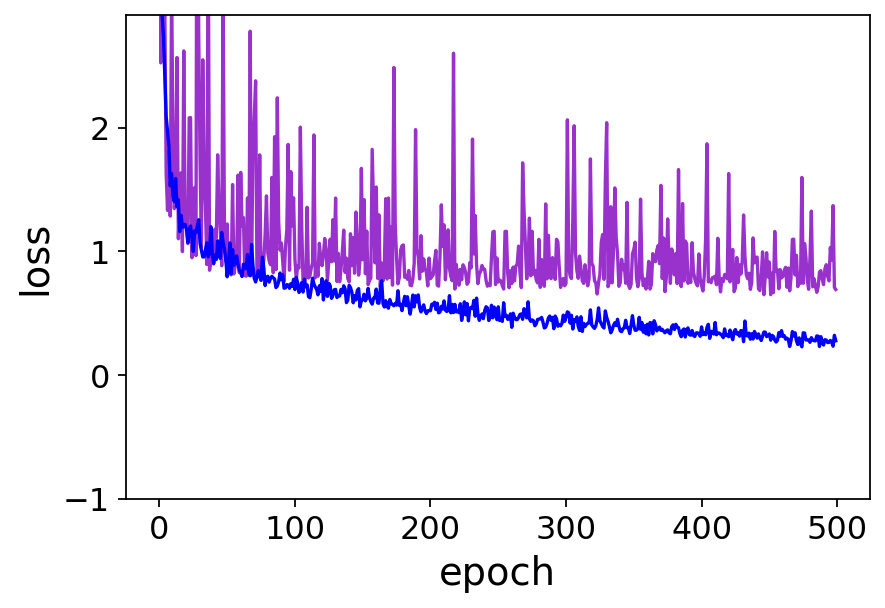

In [37]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [38]:
# plt.plot(nnfitter.loss, color='darkorchid')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [39]:
x = x_dict[feature_mode]
x_extra = x_extra_dict[feature_mode]
if x is not None:
    x_test = x[idx_test]
else:
    x_test = None
if x_extra is not None:
    x_test_extra = x_extra[idx_test]
else:
    x_test_extra = None

In [40]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


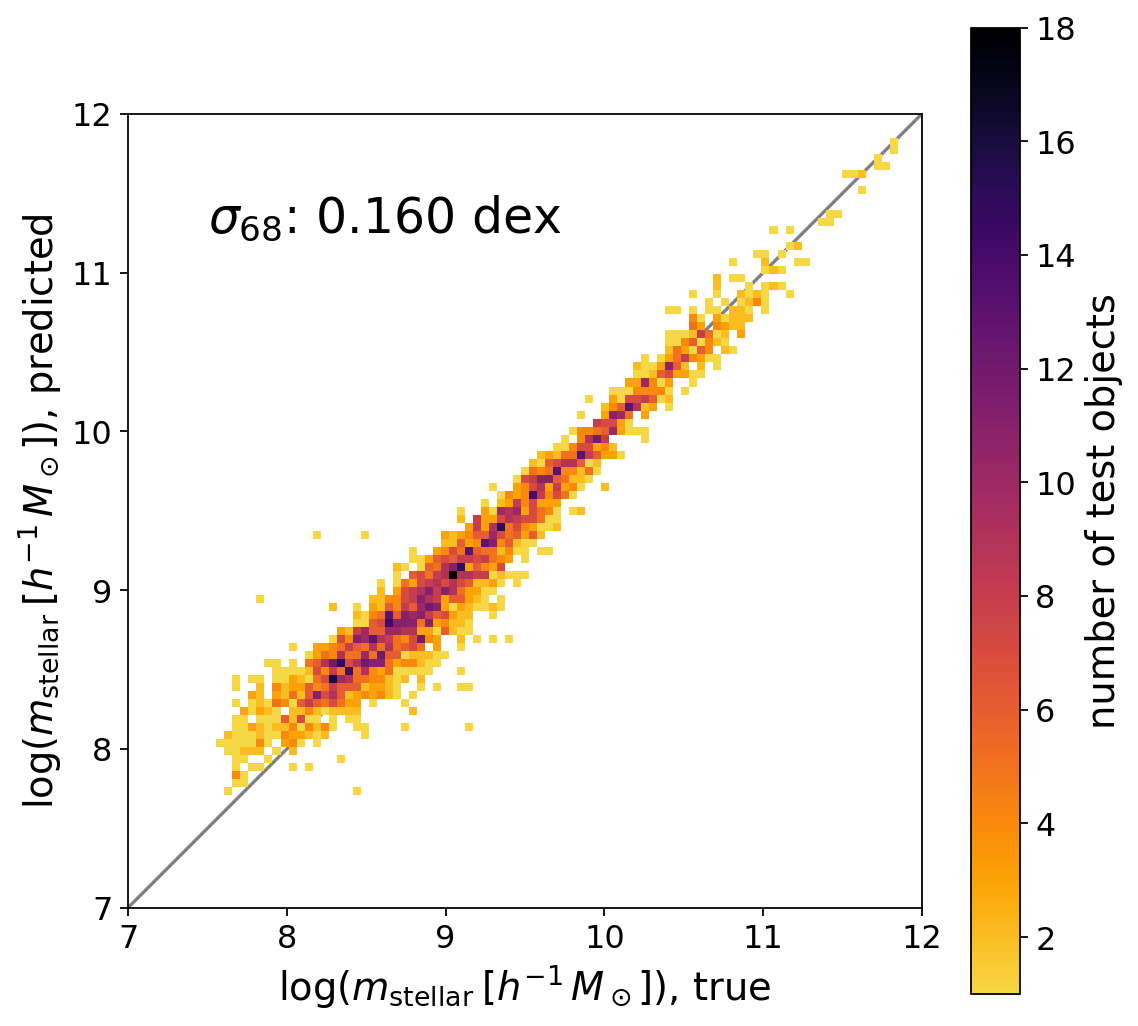

In [41]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

## Explore MofA data

In [162]:
y_label_name = 'Mofa'

In [163]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]
y_train = y[idx_train]

In [164]:
y.shape

(19670, 1)

In [165]:
avals = utils.get_avals(sim_reader.dark_halo_arr)
avals = avals[1:]

In [166]:
#avals_subset_near = [0.25, 0.5, 0.75]
avals_subset_near = [0.75]
idxs_subset = []
avals_subset = []
for aval in avals_subset_near:
    aval_closest, _ = utils.find_nearest(avals, aval)
    avals_subset.append(aval_closest)

In [69]:
np.random.seed(14)
n_ex = 8
rand_idxs = np.random.randint(len(y_train), size=n_ex)

Text(0, 0.5, '$M_\\mathrm{vir}(a)$/$M_\\mathrm{vir}(a=1)$\n of most massive progenitor halo')

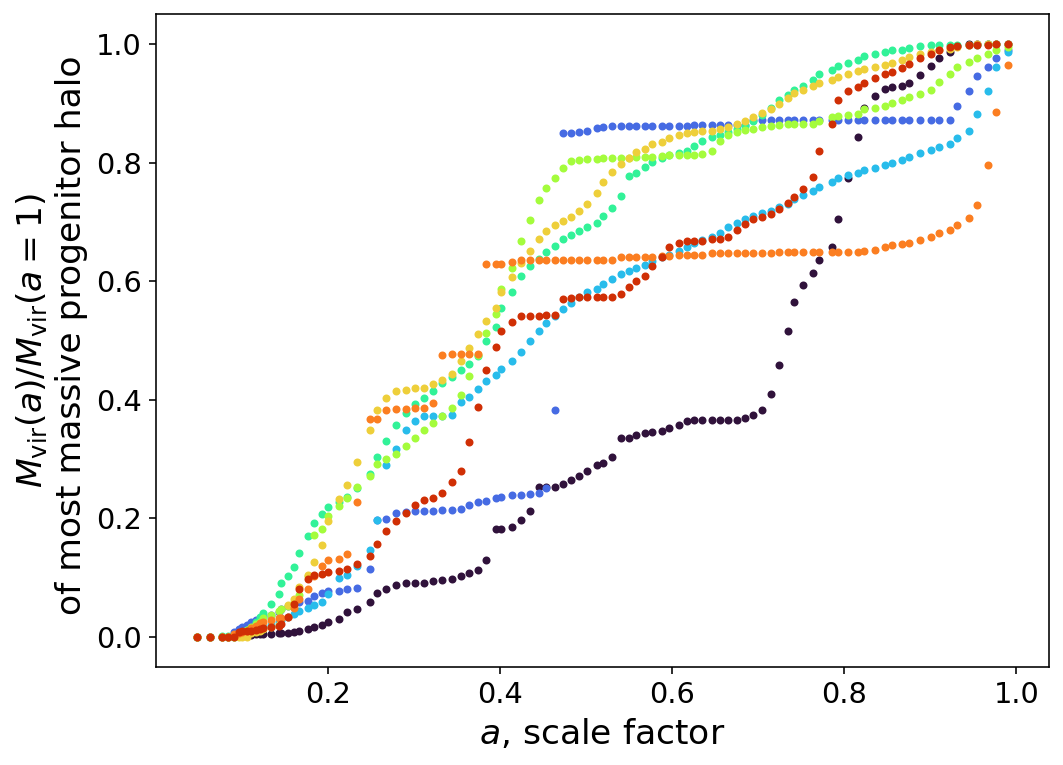

In [70]:
%matplotlib inline
plt.figure(figsize=(8,6))

locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_ex)
cmap = matplotlib.cm.get_cmap('turbo')
colors = [cmap(locs_norm(i)) for i in range(n_ex)]

for i, i_rand in enumerate(rand_idxs):
    halo = sim_reader.dark_halo_arr[i_rand]
    plt.plot(avals, y_train[i_rand], marker='o', markersize=3, ls='None', color=colors[i])

plt.xlabel(r'$a$, scale factor')
plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$'+'\n of most massive progenitor halo')

(0.0, 1.0)

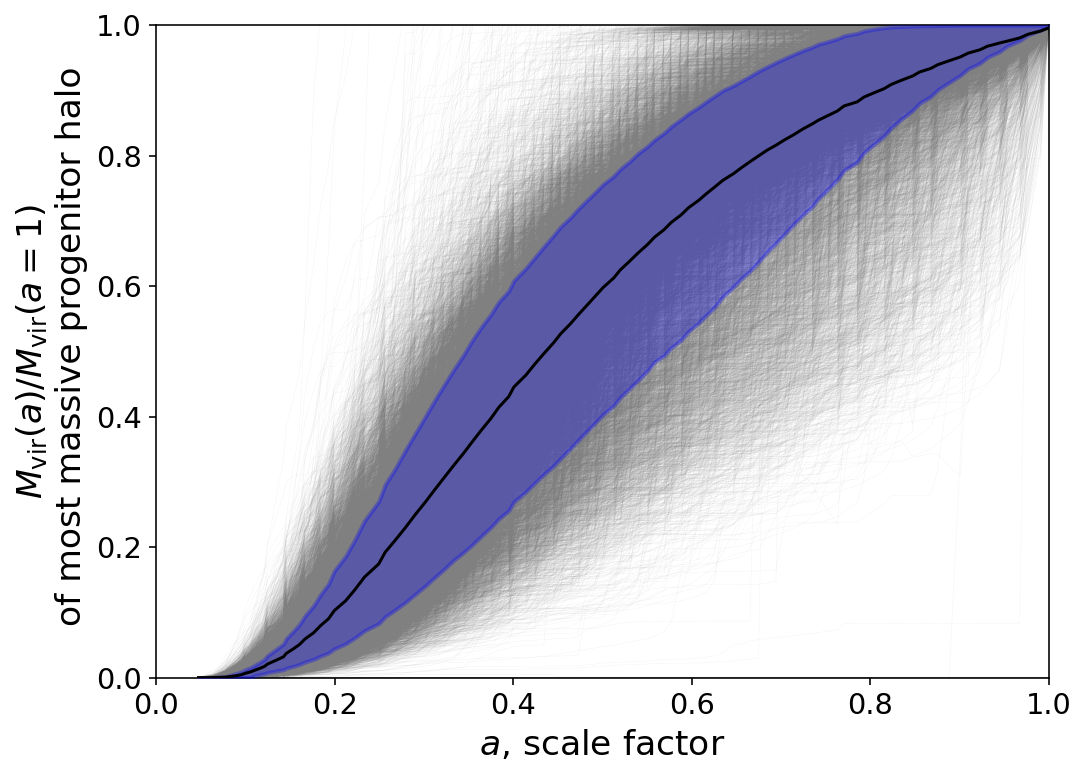

In [29]:
%matplotlib inline
plt.figure(figsize=(8,6))

locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_ex)
cmap = matplotlib.cm.get_cmap('turbo')
colors = [cmap(locs_norm(i)) for i in range(n_ex)]

y_mean = np.mean(y_train, axis=0)
#y_median = np.median(y_train, axis=0)

y_16 = np.percentile(y_train, 16, axis=0)
y_84 = np.percentile(y_train, 84, axis=0)

for i in range(len(y_train)):
    plt.plot(avals, y_train[i], lw=0.2, color='grey', alpha=0.1)

plt.fill_between(avals, y_16, y_84, color='blue', lw=2, alpha=0.3, label='sample variance', zorder=10000)
plt.plot(avals, y_mean, ls='-', color='k', zorder=10001)

plt.xlabel(r'$a$, scale factor')
plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$'+'\n of most massive progenitor halo')

plt.xlim(0, 1)
plt.ylim(0, 1)

In [188]:
max_epochs = 100
lr = 1e-5
hidden_size = 128
#feature_mode = 'scalars'
#feature_mode = 'mrv'
feature_mode = 'catalog'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs{max_epochs}_lr{lr}_hs{hidden_size}'
print(fit_tag)
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

_Mofa_nn_catalog_epochs100_lr1e-05_hs128


In [189]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

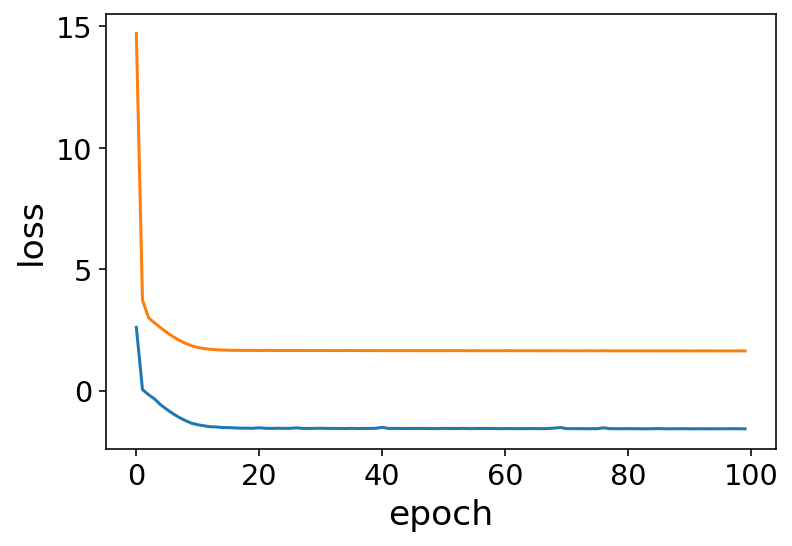

In [190]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
#print(np.min(nnfitter.loss_valid))

-1.5666002185673942


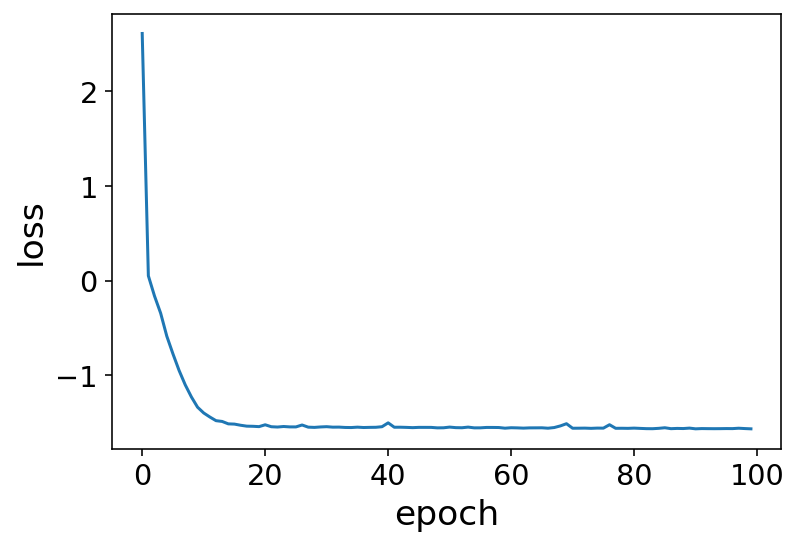

In [191]:
plt.plot(nnfitter.loss_valid)
#plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
print(np.min(nnfitter.loss_valid))

In [192]:
x = x_dict[feature_mode]
x_extra = x_extra_dict[feature_mode]
if x is not None:
    x_test = x[idx_test]
else:
    x_test = None
if x_extra is not None:
    x_test_extra = x_extra[idx_test]
else:
    x_test_extra = None

In [193]:
# x = y
# x_test = x[idx_test]
# x_test_extra = None

In [194]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

In [195]:
y_pred = np.atleast_2d(y_pred).T

In [196]:
y_test.shape, y_pred.shape

((2951, 1), (2951, 1))

In [197]:
def plot_Mofa_accuracy(M_pred, M_true, M_train, avals, title='', n_show=8):
    
    locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_show)
    cmap = matplotlib.cm.get_cmap('turbo')
    colors = [cmap(locs_norm(i)) for i in range(n_show)]

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]},
                                  figsize=(6,8))
    plt.subplots_adjust(hspace=0.03)
    fig.suptitle(title, fontsize=16)

    #errs = (M_pred - M_true)/M_true
    errs = M_pred - M_true

    np.random.seed(14)
    rand_idxs_show = np.random.randint(len(M_true), size=n_show)
    for i, i_rand in enumerate(rand_idxs_show):
        halo = sim_reader.dark_halo_arr[i_rand]

        label_true, label_pred = None, None
        if i==0:
            label_true = 'true value'
            label_pred = 'predicted value'

        ax0.plot(avals, M_true[i_rand], marker='o', markersize=4, markerfacecolor='None', ls='None', 
                 color=colors[i], label=label_true)
        ax0.plot(avals, M_pred[i_rand], color=colors[i], label=label_pred, zorder=1000)

        ax1.plot(avals, errs[i_rand], color=colors[i])

    p16 = np.percentile(errs, 16, axis=0)
    p84 = np.percentile(errs, 84, axis=0)
    sig68_avg = 0.5*(p84-p16)
    ax2.plot(avals, p16, color='k', lw=2, label='prediction error')
    ax2.plot(avals, p84, color='k', lw=2)
    ax2.axhline(0.0, color='grey', lw=1)

    # print errors
    avals_to_print_err = [0.25, 0.5, 0.75]
    errs_to_print = []
    for aval in avals_to_print_err:
        _, idx_aval = utils.find_nearest(avals, aval)
        errs_to_print.append(rf"$\sigma_{{68}}(a={aval:.2f}) = {sig68_avg[idx_aval]:.3f}$")
    
    ax0.text(0.4, 0.1, '\n'.join(errs_to_print), fontsize=14)

    # TODO: this should be based on training set, not test, i think!
    y_train_mean = np.mean(y_train, axis=0)
    #sample_var = (y_train - y_train_mean)/y_train_mean
    sample_var = y_train - y_train_mean

    sample_p16 = np.percentile(sample_var, 16, axis=0)
    sample_p84 = np.percentile(sample_var, 84, axis=0)
    ax2.fill_between(avals, sample_p16, sample_p84, color='blue', lw=2, alpha=0.3, label='sample variance')

    ax0.set_ylabel(r'$M(a)$/$M(a=1)$ of most'+'\nmassive progenitor halo')
    #ax1.set_ylabel(r'$([M/M_{a=1}]_\mathrm{pred}-[M/M_{a=1}]_\mathrm{true})/[M/M_{a=1}]_\mathrm{true}$')
    ax1.set_ylabel('frac. err.')
    ax2.set_ylabel(r'$\sigma_{68}$')

    ax2.set_xlabel(r'$a$, scale factor')

    ax0.set_ylim(0,1)
    ax1.axhline(0.0, color='grey', lw=1)

    ax0.legend(fontsize=14, loc='upper left')
    ax2.legend(fontsize=14)

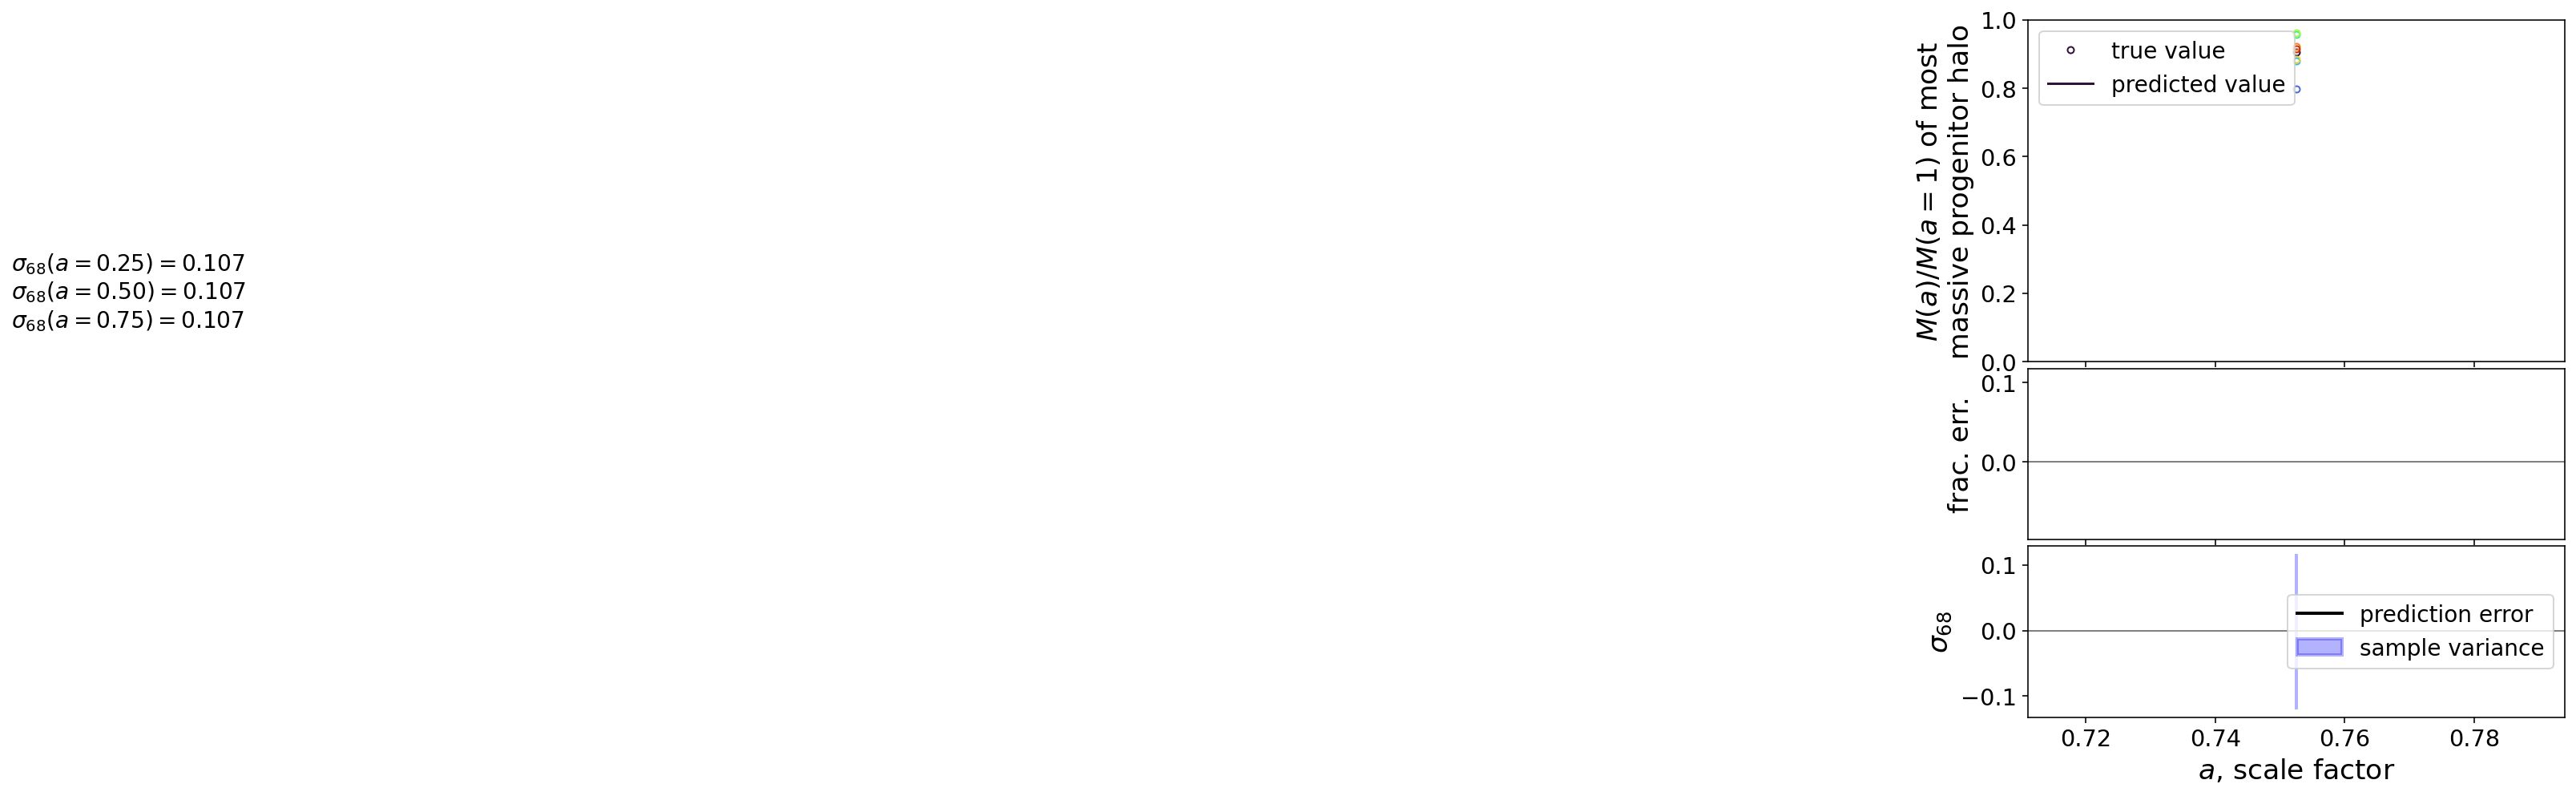

In [198]:
plot_Mofa_accuracy(y_pred, y_test, y_train, avals_subset, title='', n_show=8)

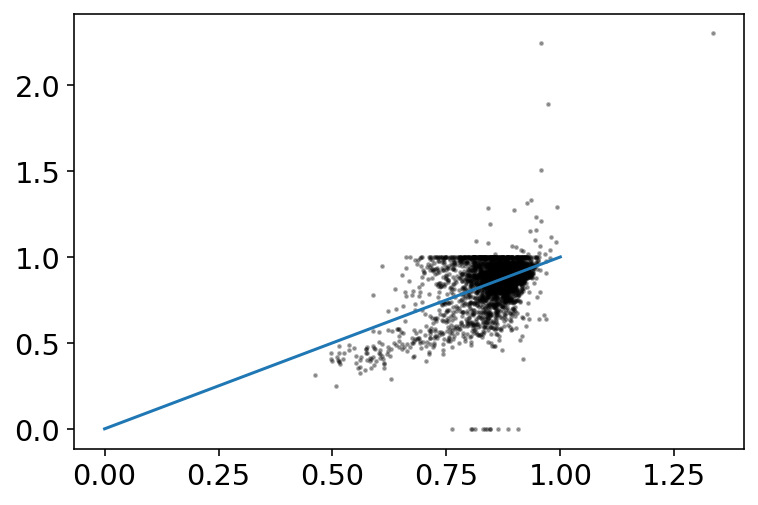

In [201]:
plt.scatter(y_pred, y_test, c='k', s=2, alpha=0.3)
plt.plot((0,1), (0,1))

In [203]:
x.shape

(19670, 3)

(-0.5, 1.5)

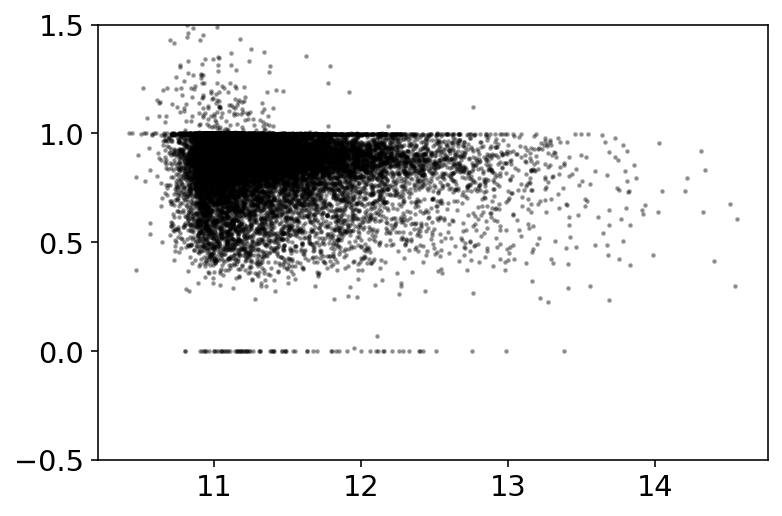

In [208]:
plt.scatter(x[:,0], y,  c='k', s=2, alpha=0.3)
plt.ylim(-0.5, 1.5)

In [209]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
print(error_nn)

[0.10673385]


# Back to a_mfrac

In [42]:
#y_label_name = 'a_mfrac_n39'
y_label_name = 'a_mfrac_n79'

In [43]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125 0.125
 0.1375 0.15   0.1625 0.175  0.1875 0.2    0.2125 0.225  0.2375 0.25
 0.2625 0.275  0.2875 0.3    0.3125 0.325  0.3375 0.35   0.3625 0.375
 0.3875 0.4    0.4125 0.425  0.4375 0.45   0.4625 0.475  0.4875 0.5
 0.5125 0.525  0.5375 0.55   0.5625 0.575  0.5875 0.6    0.6125 0.625
 0.6375 0.65   0.6625 0.675  0.6875 0.7    0.7125 0.725  0.7375 0.75
 0.7625 0.775  0.7875 0.8    0.8125 0.825  0.8375 0.85   0.8625 0.875
 0.8875 0.9    0.9125 0.925  0.9375 0.95   0.9625 0.975  0.9875]


In [44]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]
y_train = y[idx_train]

In [45]:
max_epochs = 500
lr = 5e-5
hidden_size = 128
feature_mode = 'scalars'
#feature_mode = 'mrv'
#feature_mode = 'catalog'
#feature_mode = 'geos'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs{max_epochs}_lr{lr}_hs{hidden_size}'
print(fit_tag)
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

_a_mfrac_n79_nn_scalars_epochs500_lr5e-05_hs128


In [46]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

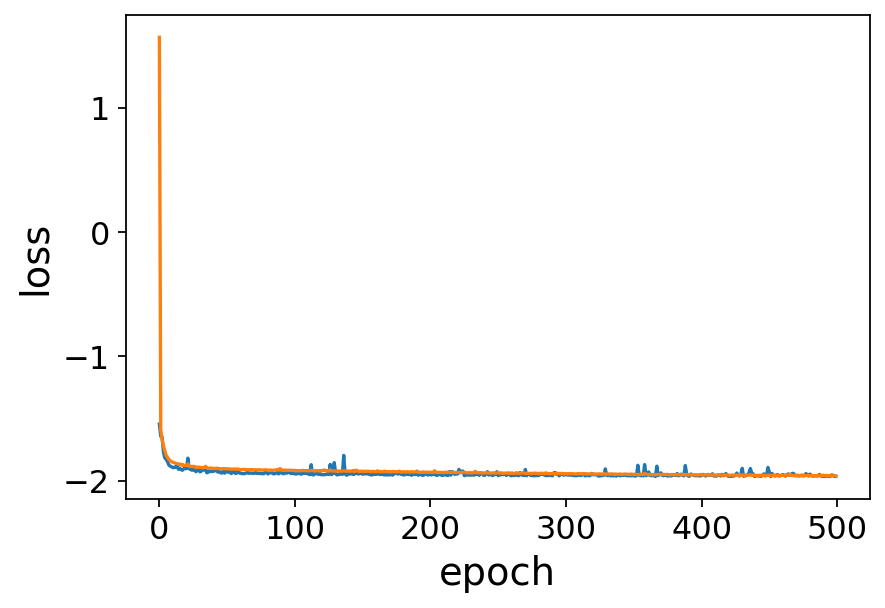

In [47]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
#print(np.min(nnfitter.loss_valid))

-1.9669844876861482


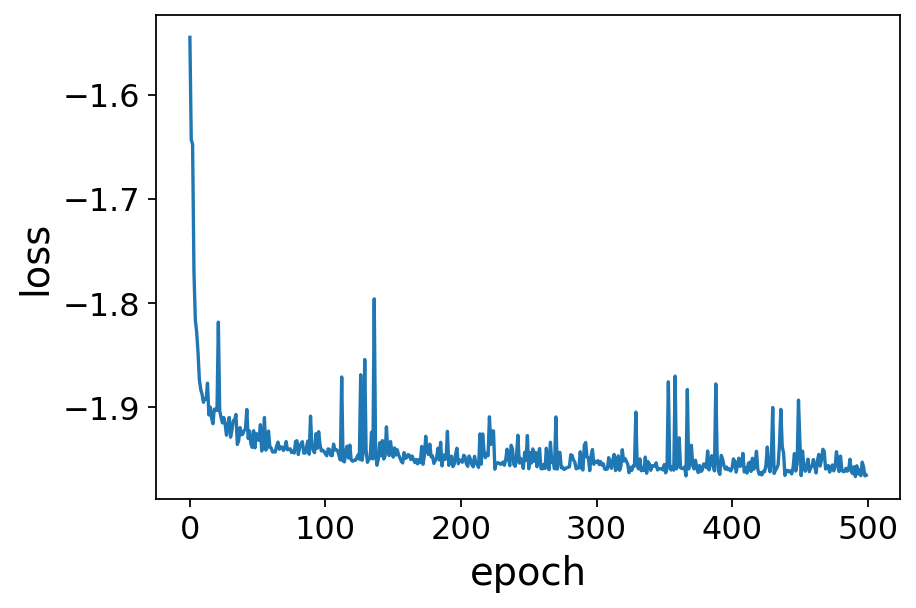

In [48]:
plt.plot(nnfitter.loss_valid)
#plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
print(np.min(nnfitter.loss_valid))

In [49]:
x = x_dict[feature_mode]
x_extra = x_extra_dict[feature_mode]
if x is not None:
    x_test = x[idx_test]
else:
    x_test = None
if x_extra is not None:
    x_test_extra = x_extra[idx_test]
else:
    x_test_extra = None

In [50]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

In [51]:
#y_pred = np.atleast_2d(y_pred).T

In [54]:
def plot_a_mfrac_accuracy(a_pred, a_true, mfracs, title='', n_show=8):
    
    locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_show)
    cmap = matplotlib.cm.get_cmap('turbo')
    colors = [cmap(locs_norm(i)) for i in range(n_show)]

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]},
                                  figsize=(6,8))
    plt.subplots_adjust(hspace=0.03)
    fig.suptitle(title, fontsize=16)

    #errs = (a_pred - a_true)/a_true
    errs = a_pred - a_true

    np.random.seed(14)
    rand_idxs_show = np.random.randint(len(a_true), size=n_show)
    for i, i_rand in enumerate(rand_idxs_show):
        halo = sim_reader.dark_halo_arr[i_rand]
        #a_mah, m_mah = halo.catalog_properties['MAH']
        #plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3, ls='None')

        label_true, label_pred = None, None
        if i==0:
            label_true = 'true value'
            label_pred = 'predicted value'

        ax0.plot(mfracs, a_true[i_rand], marker='o', markersize=4, ls='None', color=colors[i], label=label_true)
        ax0.plot(mfracs, a_pred[i_rand], color=colors[i], label=label_pred)

        ax1.plot(mfracs, errs[i_rand], color=colors[i])

    p16 = np.percentile(errs, 16, axis=0)
    p84 = np.percentile(errs, 84, axis=0)
    sig68_avg = 0.5*(p84-p16)
    ax2.plot(mfracs, p16, color='k', lw=2, label='prediction error')
    ax2.plot(mfracs, p84, color='k', lw=2)
    ax2.axhline(0.0, color='grey', lw=1)

    # print errors
    mfracs_to_print_err = [0.25, 0.5, 0.75]
    errs_to_print = []
    for mfrac in mfracs_to_print_err:
        _, idx_mfrac = utils.find_nearest(mfracs, mfrac)
        errs_to_print.append(rf"$\sigma_{{68}}(M/M_{{a=1}}={mfrac:.2f}) = {sig68_avg[idx_mfrac]:.3f}$")
    
    ax0.text(0.4, 0.1, '\n'.join(errs_to_print), fontsize=14)

    # TODO: this should be based on training set, not test, i think!
    y_test_mean = np.mean(y_test, axis=0)
    #sample_var = (y_test - y_test_mean)/y_test_mean
    sample_var = (y_test - y_test_mean)
    sample_p16 = np.percentile(sample_var, 16, axis=0)
    sample_p84 = np.percentile(sample_var, 84, axis=0)
    ax2.fill_between(mfracs, sample_p16, sample_p84, color='blue', lw=2, alpha=0.3, label='sample variance')

    ax0.set_ylabel(r'$a$, scale factor')
    #ax1.set_ylabel(r'$(a_\mathrm{pred}-a_\mathrm{true})/a_\mathrm{true}$')
    ax1.set_ylabel(r'$a_\mathrm{pred}-a_\mathrm{true}$')
    ax2.set_ylabel(r'$\sigma_{68}$')

    ax2.set_xlabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

    ax0.set_ylim(0,1)
    ax1.axhline(0.0, color='grey', lw=1)

    ax0.legend(fontsize=14, loc='upper left')
    ax2.legend(fontsize=14, loc='upper left')

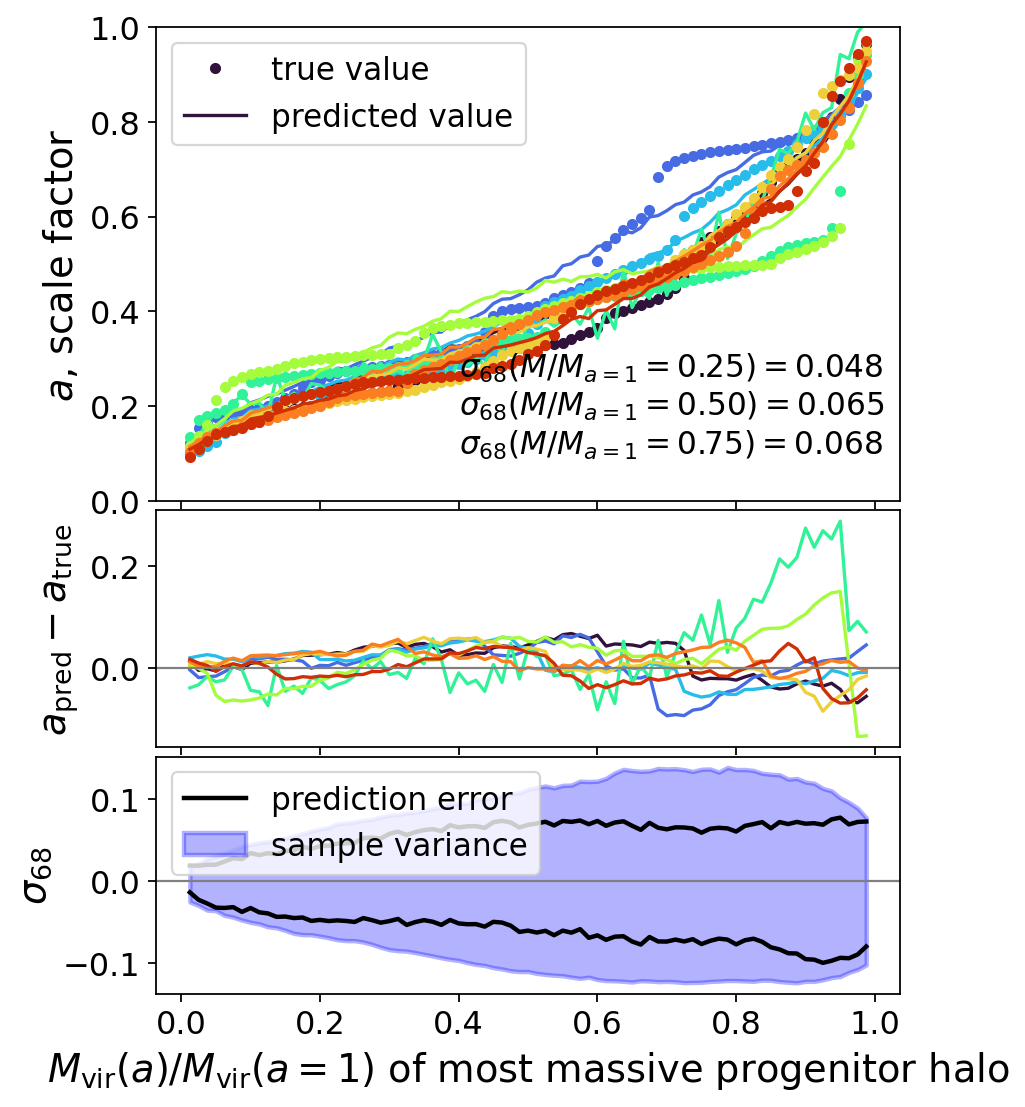

In [55]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='')